In [107]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from scipy.signal import find_peaks


total time is 50.0 sec


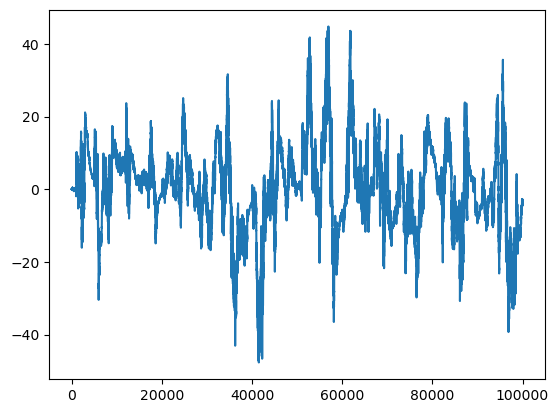

In [108]:
sampling_rate=2*1e3
sample_time=1/sampling_rate
N=100000
def ou_noise(n, dt=1.0, mu=0.0, tau=20.0, sigma=1.0, x0=0.0, rng=None):
    rng = np.random.default_rng(rng)
    x = np.empty(n)
    x[0] = x0
    a = np.exp(-dt / tau)
    sd = sigma * np.sqrt(1 - a*a)
    for t in range(1, n):
        # if t%int(tau/dt)==0:
        #     sd=sd+1e-4
        if t%int(tau/dt)==0:
             sd=random.randint(1,100)*0.01
        x[t] = mu + a*(x[t-1] - mu) + sd * rng.normal()
    return x
#I am setting tau to be 50ms

#def correlated_noise_time_varying()
x = ou_noise(N, dt=sample_time, tau=0.5, sigma=0.5)

plt.plot(x)
print("total time is",sample_time*N,"sec")

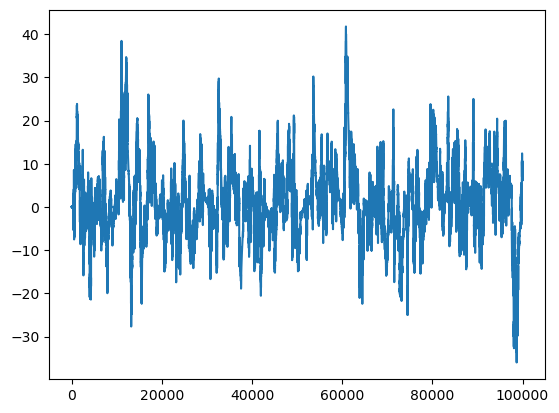

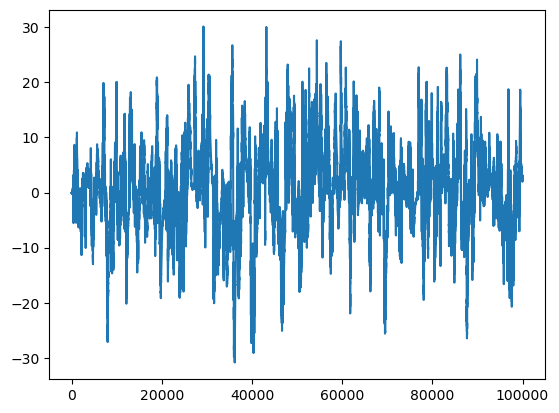

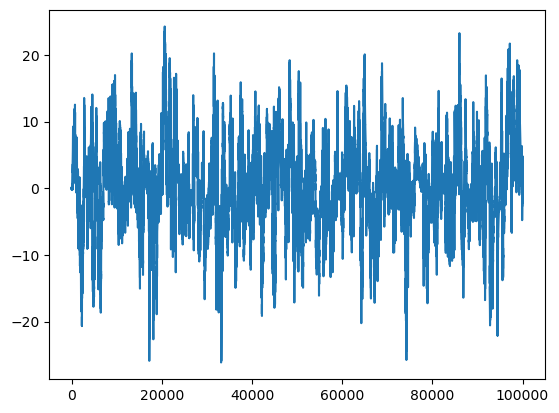

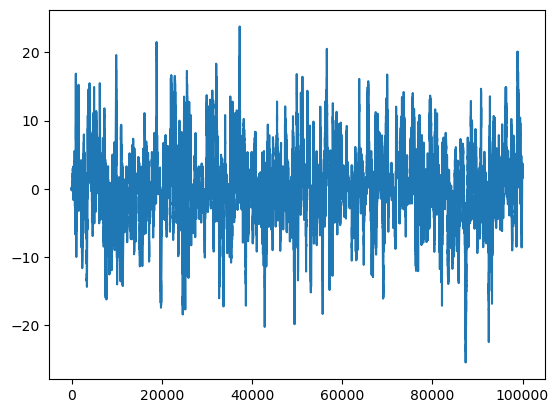

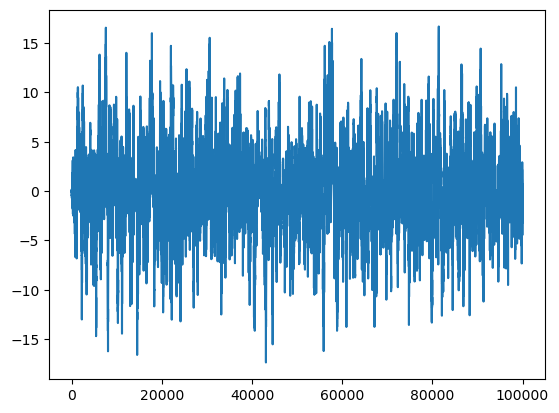

channel 1 actual coh time is 200.0 channel 2 is  120.0


In [109]:
Channel_dict={}
num_channels=5
actual_coh_time={}

rng = np.random.default_rng(12345)
Channel_dict[0]={'I':ou_noise(N,dt=sample_time,tau=0.2,sigma=0.5, rng = rng),'Q':ou_noise(N,dt=sample_time,tau=0.2,sigma=0.5, rng = rng)}
Channel_dict[1]={'I':ou_noise(N,dt=sample_time,tau=0.16,sigma=0.5, rng = rng),'Q':ou_noise(N,dt=sample_time,tau=0.16,sigma=0.5, rng = rng)}
Channel_dict[2]={'I':ou_noise(N,dt=sample_time,tau=0.12,sigma=0.5, rng = rng),'Q':ou_noise(N,dt=sample_time,tau=0.12,sigma=0.5, rng = rng)}
Channel_dict[3]={'I':ou_noise(N,dt=sample_time,tau=0.08,sigma=0.5, rng = rng),'Q':ou_noise(N,dt=sample_time,tau=0.08,sigma=0.5, rng = rng)}
Channel_dict[4]={'I':ou_noise(N,dt=sample_time,tau=0.04,sigma=0.5, rng = rng),'Q':ou_noise(N,dt=sample_time,tau=0.04,sigma=0.5, rng = rng)}

plt.plot(Channel_dict[0]["I"])
plt.show()
plt.plot(Channel_dict[1]["I"])
plt.show()
plt.plot(Channel_dict[2]["I"])
plt.show()
plt.plot(Channel_dict[3]["I"])
plt.show()
plt.plot(Channel_dict[4]["I"])
plt.show()

print("channel 1 actual coh time is",0.1/sample_time,"channel 2 is ",0.06/sample_time)

In [110]:
initial_scan_duration = int(50 / sample_time)        # 50 seconds simulated pre-scan
NOP_duration = int(10 / sample_time)       # 10 seconds simulated NOP

In [111]:
from numpy.fft import rfft, irfft

def autocorr_fft_smooth(x):
    x = np.asarray(x)
    x = x - x.mean()  # optional, improves robustness
    n = len(x)
    nfft = 1 << (2 * n - 1).bit_length()  # next power of 2 for speed
    X = rfft(x, nfft)
    r = irfft(X * np.conj(X), nfft)[:n]  # non-negative lags
    r = r / (r[0] + 1e-20)  # normalize

    # --- Apply 10-sample moving average smoothing ---
    #window_size = 1024
    window_size = 50
    kernel = np.ones(window_size) / window_size
    r_smooth = np.convolve(r, kernel, mode='same')

    return r_smooth

def find_coh_time_fft(x, threshold=1/3):
    r = autocorr_fft_smooth(x)
    # first lag where it drops below threshold
    idx = np.argmax(r <= threshold)  # returns 0 if first element meets
    if r[0] <= threshold:            # guard unlikely case
        return 0
    if idx == 0:                     # no drop found
        return len(r)                # cap at window length
    return idx

print("samples taken to find coherence",int(10/sample_time))

samples taken to find coherence 20000


In [112]:
def dfs_check_radar(signal):
    """Simulate radar detection by random chance."""
    return True


def initial_prescan_and_init_coherence(Channel_dict, scan_duration):
    """Perform DFS pre-scan + initial coherence estimation."""
    dfs_states = {}
    dfs_timers = {}
    dict_coherence_times = {}

    for ch in Channel_dict:
        # Simulate CAC (pre-scan)
        I_part = Channel_dict[ch]["I"][:scan_duration]
        Q_part = Channel_dict[ch]["Q"][:scan_duration]
        # radar_present = dfs_check_radar(I_part) or dfs_check_radar(Q_part)
        radar_present = False

        if radar_present:
            dfs_states[ch] = "NOP"
            dfs_timers[ch] = 0
        else:
            dfs_states[ch] = "AVAILABLE"
            dfs_timers[ch] = 0

        dict_coherence_times[ch] = {
            "I": find_coh_time_fft(I_part),
            "Q": find_coh_time_fft(Q_part),
        }
    print(dfs_states)

    return dfs_states, dfs_timers, dict_coherence_times

def update_dfs_states(dfs_states, dfs_timers, elapsed_samples):
    """Update NOP timers by elapsed_samples and move expired ones to RESCAN."""
    if elapsed_samples <= 0:
        return

    for ch in list(dfs_states.keys()):
        if dfs_states[ch] == "NOP":
            dfs_timers[ch] += elapsed_samples
            print(f"nop channel {ch}: timer += {elapsed_samples} -> {dfs_timers[ch]} (needs {NOP_duration})")
            if dfs_timers[ch] >= NOP_duration:
                dfs_states[ch] = "RESCAN"
                dfs_timers[ch] = 0
                print(f"Channel {ch} NOP expired -> RESCAN")
        else:
            # no change for non-NOP channels
            pass


def rescan_channels(dfs_states, dfs_timers, Channel_dict, sample_index, scan_duration):
    """Perform CAC again for channels marked RESCAN."""
    for ch in dfs_states:
        if dfs_states[ch] == "RESCAN":
            start = sample_index
            end = min(sample_index + scan_duration, N)
            I_part = Channel_dict[ch]["I"][start:end]
            Q_part = Channel_dict[ch]["Q"][start:end]
            # radar_present = dfs_check_radar(I_part) or dfs_check_radar(Q_part)
            radar_present = (sample_index > 10000 and sample_index < 10500)
            if radar_present:
                dfs_states[ch] = "NOP"
                dfs_timers[ch] = 0
                print(f"[DFS] Channel {ch}: Radar detected again → NOP")
            else:
                dfs_states[ch] = "AVAILABLE"
                dfs_timers[ch] = 0
                print(f"[DFS] Channel {ch}: Cleared → AVAILABLE")

def available_channels(dfs_states):
    return [ch for ch, st in dfs_states.items() if st == "AVAILABLE"]

492


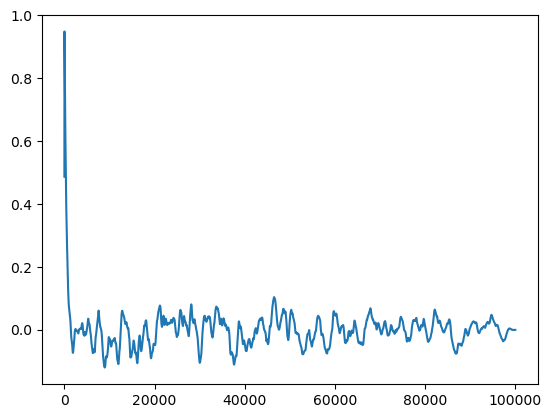

298


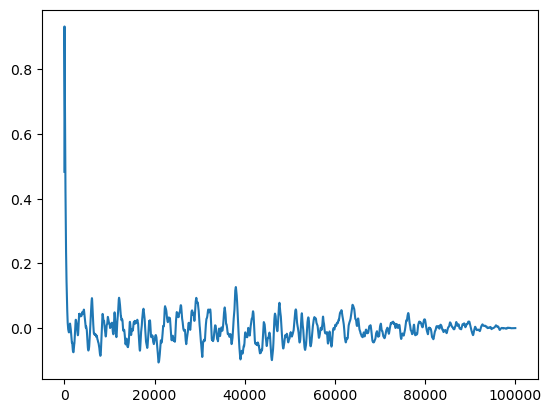

In [113]:
total_samples_plot=initial_scan_duration
# total_samples_plot = 10000
plt.plot(autocorr_fft_smooth(Channel_dict[0]["I"][:total_samples_plot]))
print(find_coh_time_fft(Channel_dict[0]["I"][:total_samples_plot]))
plt.show()
plt.plot(autocorr_fft_smooth(Channel_dict[1]["I"][:total_samples_plot]))
print(find_coh_time_fft(Channel_dict[1]["I"][:total_samples_plot]))

In [114]:
# multi armed bandit to select next channel to scan
#Right now the dwell time of stuff is around max 20000 samples
dfs_states, dfs_timers, dict_coherence_times = initial_prescan_and_init_coherence(Channel_dict, initial_scan_duration)
print(dict_coherence_times)

#we will create a coherence probability array
total_dwell_sum=0
for channel in dict_coherence_times:
    total_dwell_sum+=1/min(dict_coherence_times[channel]["I"],dict_coherence_times[channel]["Q"])

dwell_probabilities={}
for channel in dict_coherence_times:
    dwell_probabilities[channel]=(1/min(dict_coherence_times[channel]["I"],dict_coherence_times[channel]["Q"]))/total_dwell_sum

# check_sum=0
# for channel in dwell_probabilities:
#     check_sum+=dwell_probabilities[channel]

# print(check_sum)
print(dwell_probabilities)

#Using min dwell time as 0.5sec
min_dwell_samples=int(1/sample_time)

print("Min dwell samples is",min_dwell_samples)
prob_1_dwell_samples=min_dwell_samples/min(dwell_probabilities.values())
print(prob_1_dwell_samples)

{0: 'AVAILABLE', 1: 'AVAILABLE', 2: 'AVAILABLE', 3: 'AVAILABLE', 4: 'AVAILABLE'}
{0: {'I': 492, 'Q': 379}, 1: {'I': 298, 'Q': 302}, 2: {'I': 278, 'Q': 263}, 3: {'I': 166, 'Q': 196}, 4: {'I': 92, 'Q': 84}}
{0: 0.0951663668850256, 1: 0.12103373506518357, 2: 0.13714088611948558, 3: 0.21727742800858257, 4: 0.42938158392172265}
Min dwell samples is 2000
21015.828022690857


In [115]:
# each channel is one arm
num_channels = 5 # number of arms

arm_coherent_time = {}

arm_dwell_time = {}
for channel in dwell_probabilities:
    arm_dwell_time[channel]=int(dwell_probabilities[channel]*prob_1_dwell_samples)    

arms_with_reward = {}
arm_last_played_time = {}
arm_coherent_time = {}

#We want dwell time min to be about 0.5sec

for i in range(num_channels):
    arms_with_reward[i] = 0
    arm_last_played_time[i] = 0
    arm_coherent_time[i] = min(dict_coherence_times[i]['I'], dict_coherence_times[i]['Q'])
    #arm_coherent_time[i] = random.randint(400, 1000)
    #arm_dwell_time[i] = int(1e7 / arm_coherent_time[i]) # seems correct

print("initialised dwell times", arm_dwell_time)

initialised dwell times {0: 2000, 1: 2543, 2: 2882, 3: 4566, 4: 9023}


In [116]:
def get_reward(channel_chosen, current_sample_index, arm_last_played_time, arm_coherent_time):
    reward = (current_sample_index - arm_last_played_time[channel_chosen])/arm_coherent_time[channel_chosen]
    return (reward)

In [117]:
def selected_arm(epsilon, available):
    k = random.random()
    if (k < epsilon) :
        next_arm = random.choice(available)
    else:
        next_arm = max(arms_with_reward, key = arms_with_reward.get)
    return(next_arm)

In [118]:
Wifi_output_samples={}
temp_output_samples = {}
for channel in Channel_dict:
    Wifi_output_samples[channel]={'I':[],'Q':[]}  # storing in the form of a list of elements (sample_num,value) for I and Q
epsilon = 1
alpha=0.95
# epsilon_decay = 0.995
total_samples = N
print(total_samples)

current_sample_index = 0
last_update_index = 0
while(current_sample_index<total_samples):
    elapsed = current_sample_index - last_update_index
    print(current_sample_index > 100000 and current_sample_index < 108000)

    update_dfs_states(dfs_states, dfs_timers, elapsed)
    rescan_channels(dfs_states, dfs_timers, Channel_dict, current_sample_index, initial_scan_duration)
    last_update_index = current_sample_index
    available = available_channels(dfs_states)
    print(dfs_states)

    if not available:
        current_sample_index += 100 #just waiting some time till something gets available
        continue

    temp_output_samples = {}

    for i in (available):
        arms_with_reward[i] = get_reward(i, current_sample_index, arm_last_played_time, arm_coherent_time)

    next_arm = selected_arm(epsilon, available)

    # Simulate radar detection mid-operation
    radar_present = (current_sample_index > 100000 and current_sample_index < 108000)
    #if dfs_check_radar(Channel_dict[next_arm]["I"][current_sample_index:current_sample_index + arm_dwell_time[next_arm]]):
    if (radar_present):
        print("before increment", current_sample_index)
        dfs_states[next_arm] = "NOP"
        dfs_timers[next_arm] = 0
        print(f"[DFS] Radar detected on channel {next_arm} during dwell → NOP")
        current_sample_index += arm_dwell_time[next_arm]
        print("testing increment", current_sample_index)
        #print(dfs_states)
        continue

    temp_output_samples[next_arm] = {}
    temp_output_samples[next_arm]['I'] = []
    temp_output_samples[next_arm]['Q'] = []
    arms_with_reward[next_arm] = 0

    #print(available)

    for i in range(arm_dwell_time[next_arm]):
        if current_sample_index==total_samples-1:
            current_sample_index+=1
            break
        Wifi_output_samples[next_arm]['I'].append([current_sample_index, Channel_dict[next_arm]['I'][current_sample_index]])
        Wifi_output_samples[next_arm]['Q'].append([current_sample_index, Channel_dict[next_arm]['Q'][current_sample_index]])
        temp_output_samples[next_arm]['I'].append(Channel_dict[next_arm]['I'][current_sample_index])
        temp_output_samples[next_arm]['Q'].append(Channel_dict[next_arm]['Q'][current_sample_index])
        current_sample_index+=1

    # print(temp_output_samples)
    _, _, coh_time_to_update = initial_prescan_and_init_coherence(temp_output_samples, arm_dwell_time[next_arm])
    arm_coherent_time[next_arm] = alpha*arm_coherent_time[next_arm]+(1-alpha)*min(coh_time_to_update[next_arm]['I'], coh_time_to_update[next_arm]['Q'])
    arm_dwell_time[next_arm] = int(((1/ arm_coherent_time[next_arm])/total_dwell_sum)*prob_1_dwell_samples) # seems correct
    print(arm_dwell_time)
    arm_last_played_time[next_arm] = current_sample_index

100000
False
{0: 'AVAILABLE', 1: 'AVAILABLE', 2: 'AVAILABLE', 3: 'AVAILABLE', 4: 'AVAILABLE'}
{1: 'AVAILABLE'}
{0: 2000, 1: 2628, 2: 2882, 3: 4566, 4: 9023}
False
{0: 'AVAILABLE', 1: 'AVAILABLE', 2: 'AVAILABLE', 3: 'AVAILABLE', 4: 'AVAILABLE'}
{3: 'AVAILABLE'}
{0: 2000, 1: 2628, 2: 2882, 3: 4578, 4: 9023}
False
{0: 'AVAILABLE', 1: 'AVAILABLE', 2: 'AVAILABLE', 3: 'AVAILABLE', 4: 'AVAILABLE'}
{0: 'AVAILABLE'}
{0: 2060, 1: 2628, 2: 2882, 3: 4578, 4: 9023}
False
{0: 'AVAILABLE', 1: 'AVAILABLE', 2: 'AVAILABLE', 3: 'AVAILABLE', 4: 'AVAILABLE'}
{3: 'AVAILABLE'}
{0: 2060, 1: 2628, 2: 2882, 3: 4669, 4: 9023}
False
{0: 'AVAILABLE', 1: 'AVAILABLE', 2: 'AVAILABLE', 3: 'AVAILABLE', 4: 'AVAILABLE'}
{0: 'AVAILABLE'}
{0: 2123, 1: 2628, 2: 2882, 3: 4669, 4: 9023}
False
{0: 'AVAILABLE', 1: 'AVAILABLE', 2: 'AVAILABLE', 3: 'AVAILABLE', 4: 'AVAILABLE'}
{2: 'AVAILABLE'}
{0: 2123, 1: 2628, 2: 2959, 3: 4669, 4: 9023}
False
{0: 'AVAILABLE', 1: 'AVAILABLE', 2: 'AVAILABLE', 3: 'AVAILABLE', 4: 'AVAILABLE'}
{1: 'A

In [119]:
#print(arm_stddev)
#print(arm_mean_time)
# for i in range(num_channels):
#     print(Wifi_output_samples[i]['I'][:100])

print(arm_dwell_time)

{0: 2327, 1: 2864, 2: 3091, 3: 4803, 4: 9355}


In [120]:
def get_sampled_channel(data,total_num_samples):
    "The input data is of the form [index,value] we need to be able to diffrentiate between periodic and non periodic signals to do this we are just linearly interpolating in stft"
    output_wifi_samples={}
    for channel in data:
        
        output_wifi_samples[channel]={'I':np.array([0 for i in range(total_num_samples)]),'Q':np.array([0 for i in range(total_num_samples)])}
        I = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['I']:
            idx = int(cur_sample)
            I[idx] = float(val)
        output_wifi_samples[channel]['I'] = I  # ensure the mutated array is stored
        Q = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['Q']:
            idx = int(cur_sample)
            Q[idx] = float(val)
        output_wifi_samples[channel]['Q'] = Q  # ensure the mutated array is stored

    return output_wifi_samples

output_samples_for_each_channel=get_sampled_channel(Wifi_output_samples,N)



In [121]:
# #plt.plot(output_samples_for_each_channel[1]['I'])
# index=2
# plt.plot(output_samples_for_each_channel[2]['I'])
# plt.show()
# plt.plot(Channel_dict[2]["I"])
# #print(len())

Doing Naive method

In [122]:
Wifi_naive_symbols={}
size_of_naive_samples_per_channel=min_dwell_samples

cur_num=0
for channel in Channel_dict:
    Wifi_naive_symbols[channel]={'I':[],'Q':[]}

while cur_num<total_samples:
    for channel in Channel_dict:
        for i in range(size_of_naive_samples_per_channel):
            Wifi_naive_symbols[channel]['I'].append((cur_num,Channel_dict[channel]['I'][cur_num]))
            Wifi_naive_symbols[channel]['Q'].append((cur_num,Channel_dict[channel]['Q'][cur_num]))
            cur_num+=1
        #cur_num+=size_of_naive_samples_per_channel
        if cur_num>=total_samples:
            break
#I = np.zeros(2_000_000, dtype=np.float64)  # force float64
print(Wifi_naive_symbols[1]['I'][:100])
#Wifi_naive_symbols[channel]['I'] = I  # ensure the mutated array is stored

[(2000, -4.168430235077465), (2001, -4.348303750304427), (2002, -3.7591466132633347), (2003, -3.1276573166802706), (2004, -3.2973999966931173), (2005, -3.248601071970819), (2006, -3.58527625224556), (2007, -3.1276464134073643), (2008, -4.186116669763404), (2009, -5.036620053107626), (2010, -5.0171999895310435), (2011, -6.324925314066438), (2012, -6.002897205546636), (2013, -4.875679389413665), (2014, -5.722858415644151), (2015, -5.32836594147484), (2016, -6.252762506205351), (2017, -7.084837405240453), (2018, -6.611328827284689), (2019, -6.433268945227868), (2020, -6.5072489238638), (2021, -6.537645217765785), (2022, -5.767922116897364), (2023, -5.839447485736801), (2024, -5.164341514420492), (2025, -4.65989633886515), (2026, -4.454533891491724), (2027, -3.676565284555678), (2028, -3.426656937235419), (2029, -3.8322858474232957), (2030, -3.8467613387863633), (2031, -4.007643348081023), (2032, -4.027943579694636), (2033, -4.229224981786208), (2034, -3.9556113267747217), (2035, -4.289844

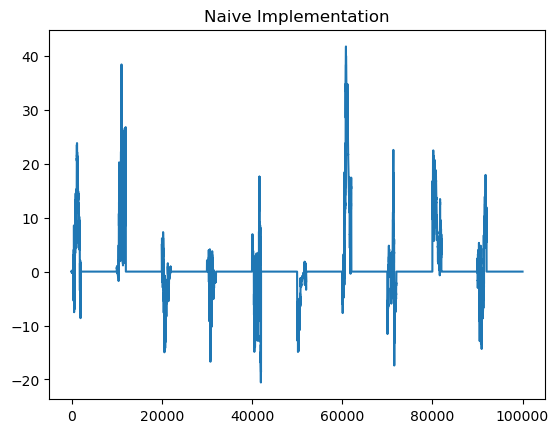

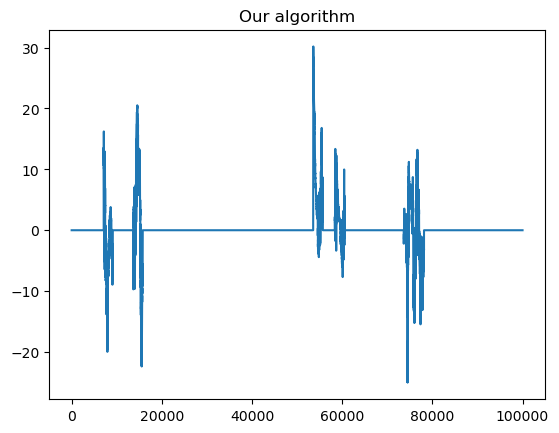

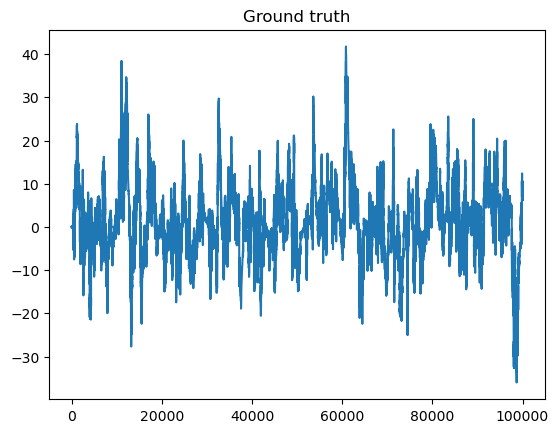

In [123]:
Wifi_output_data_after_interpolation_naive=get_sampled_channel(Wifi_naive_symbols,N)

index=0

plt.title("Naive Implementation")
plt.plot(Wifi_output_data_after_interpolation_naive[index]['I'])
plt.show()
plt.title("Our algorithm")
plt.plot(output_samples_for_each_channel[index]['I'])
plt.show()
plt.title("Ground truth")
plt.plot(Channel_dict[index]["I"])

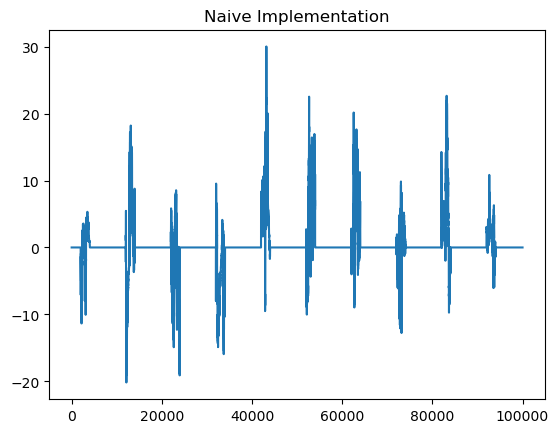

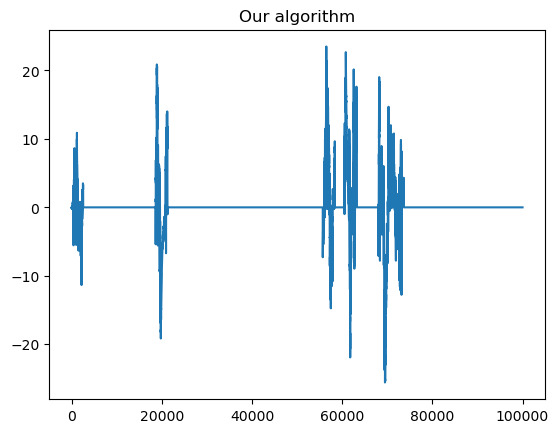

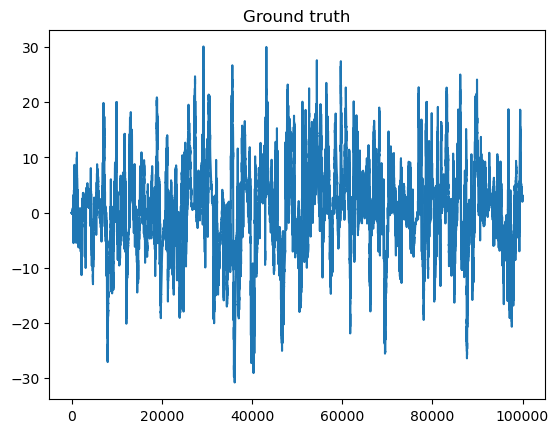

In [124]:
Wifi_output_data_after_interpolation_naive=get_sampled_channel(Wifi_naive_symbols,N)

index=1

plt.title("Naive Implementation")
plt.plot(Wifi_output_data_after_interpolation_naive[index]['I'])
plt.show()
plt.title("Our algorithm")
plt.plot(output_samples_for_each_channel[index]['I'])
plt.show()
plt.title("Ground truth")
plt.plot(Channel_dict[index]["I"])

In [125]:
def finding_power(output_samples_for_each_channel, sample_time, num_channels, total_samples):
    """
    Compute per-channel power in fixed-size sample blocks and fill zeros
    between nonzero stretches with the average power of the previous stretch.

    Returns:
        power_per_channel: {
            channel_index: {
                'I': np.ndarray of shape (total_samples,),
                'Q': np.ndarray of shape (total_samples,)
            }
        }
    """
    sampleblock_length = int((0.5 / sample_time) // 10)
    power_per_channel = {}

    for i in range(num_channels):
        I_signal = np.array(output_samples_for_each_channel[i]['I'])
        Q_signal = np.array(output_samples_for_each_channel[i]['Q'])

        power_I = np.zeros(total_samples)
        power_Q = np.zeros(total_samples)

        nonzero_mask = (I_signal != 0) | (Q_signal != 0)
        diff_mask = np.diff(nonzero_mask.astype(int))
        starts = np.where(diff_mask == 1)[0] + 1  # rising edges
        ends = np.where(diff_mask == -1)[0] + 1   # falling edges

        # handle cases where signal starts or ends as nonzero
        if nonzero_mask[0]:
            starts = np.insert(starts, 0, 0)
        if nonzero_mask[-1]:
            ends = np.append(ends, total_samples)

        prev_end = 0
        avg_power_I = 0
        avg_power_Q = 0

        for s, e in zip(starts, ends):
            stretch_len = e - s
            n_blocks = int(np.ceil(stretch_len / sampleblock_length))

            block_powers_I = []
            block_powers_Q = []

            for b in range(n_blocks):
                start_idx = s + b * sampleblock_length
                end_idx = min(s + (b + 1) * sampleblock_length, e)

                I_block = I_signal[start_idx:end_idx]
                Q_block = Q_signal[start_idx:end_idx]

                block_power_I = np.mean(I_block**2)
                block_power_Q = np.mean(Q_block**2)

                power_I[start_idx:end_idx] = block_power_I
                power_Q[start_idx:end_idx] = block_power_Q

                block_powers_I.append(block_power_I)
                block_powers_Q.append(block_power_Q)

            avg_power_I = np.mean(block_powers_I)
            avg_power_Q = np.mean(block_powers_Q)

            # fill zeros before this stretch with average power from current stretch
            if prev_end < s:
                power_I[prev_end:s] = avg_power_I
                power_Q[prev_end:s] = avg_power_Q

            prev_end = e

        # fill tail after last stretch
        if prev_end < total_samples:
            power_I[prev_end:] = avg_power_I
            power_Q[prev_end:] = avg_power_Q

        power_per_channel[i] = {'I': power_I, 'Q': power_Q}

    return power_per_channel

In [126]:
#sample_time = 1/(2*1e4)

result = finding_power(output_samples_for_each_channel, sample_time, num_channels, total_samples)

print("Channel 0 Power (first 20 samples):")
print(result[0]['I'][:20])

result_naive = finding_power(Wifi_output_data_after_interpolation_naive, sample_time, num_channels, total_samples)

print("Channel 0 Power (first 20 samples):")
print(result_naive[0]['I'][:20])

result_ground_truth = finding_power(Channel_dict, sample_time, num_channels, total_samples)


Channel 0 Power (first 20 samples):
[44.32968431 44.32968431 44.32968431 44.32968431 44.32968431 44.32968431
 44.32968431 44.32968431 44.32968431 44.32968431 44.32968431 44.32968431
 44.32968431 44.32968431 44.32968431 44.32968431 44.32968431 44.32968431
 44.32968431 44.32968431]
Channel 0 Power (first 20 samples):
[1.00473729e+02 1.07292989e-02 1.07292989e-02 1.07292989e-02
 1.07292989e-02 1.07292989e-02 1.07292989e-02 1.07292989e-02
 1.07292989e-02 1.07292989e-02 1.07292989e-02 1.07292989e-02
 1.07292989e-02 1.07292989e-02 1.07292989e-02 1.07292989e-02
 1.07292989e-02 1.07292989e-02 1.07292989e-02 1.07292989e-02]


In [127]:
def plot_power_and_signals(output_samples_for_each_channel, power_per_channel, num_channels_1):
    """
    Plot I/Q signals and their computed power for each channel.
    """
    fig, axs = plt.subplots(num_channels_1, 2, figsize=(12, 6), sharex=True)

    for i in range(num_channels_1):
        # Extract data
        I_signal = np.array(output_samples_for_each_channel[i]['I'])
        Q_signal = np.array(output_samples_for_each_channel[i]['Q'])
        power_I = power_per_channel[i]['I']
        power_Q = power_per_channel[i]['Q']
        samples = np.arange(len(I_signal))

        # --- I component ---
        axs[i, 0].plot(samples, I_signal, label="I signal", color='steelblue', alpha=0.7)
        axs[i, 0].plot(samples, power_I, label="I power", color='crimson', linestyle='--', linewidth=2)
        axs[i, 0].set_title(f"Channel {i} - I Component")
        axs[i, 0].set_ylabel("Amplitude / Power")
        axs[i, 0].legend()
        axs[i, 0].grid(True, linestyle='--', alpha=0.4)

        # --- Q component ---
        axs[i, 1].plot(samples, Q_signal, label="Q signal", color='darkgreen', alpha=0.7)
        axs[i, 1].plot(samples, power_Q, label="Q power", color='orange', linestyle='--', linewidth=2)
        axs[i, 1].set_title(f"Channel {i} - Q Component")
        axs[i, 1].legend()
        axs[i, 1].grid(True, linestyle='--', alpha=0.4)

    axs[-1, 0].set_xlabel("Sample Index")
    axs[-1, 1].set_xlabel("Sample Index")
    plt.suptitle("Original Signals and Computed Power per Channel", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

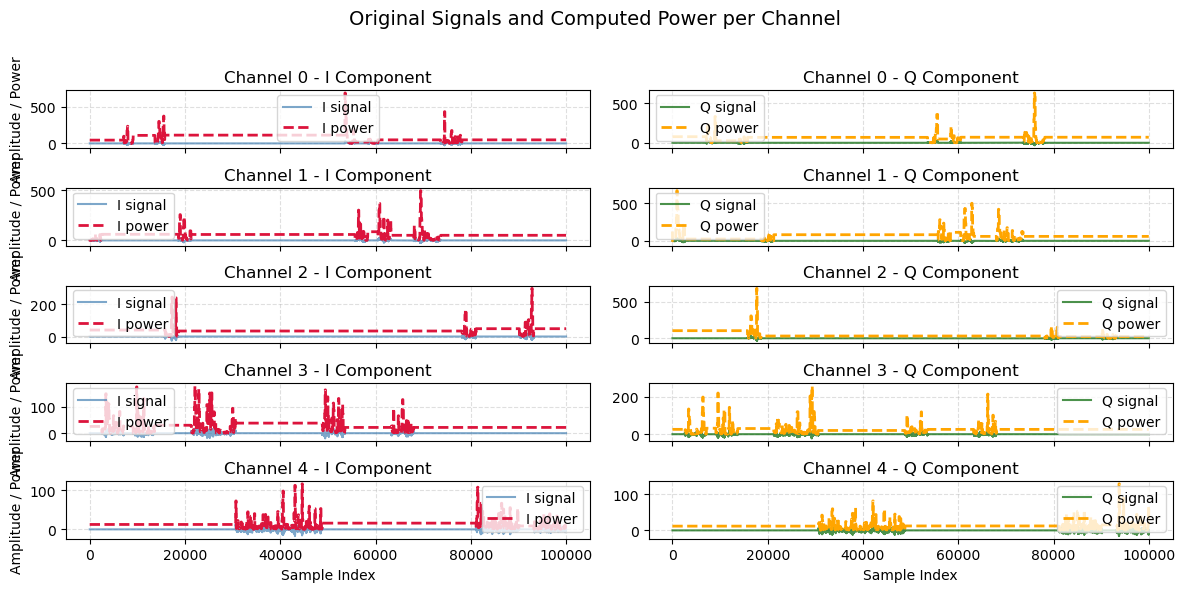

In [128]:
# plot_power_and_signals(output_samples_for_each_channel, result, num_channels)
plot_power_and_signals(output_samples_for_each_channel, result, 5)

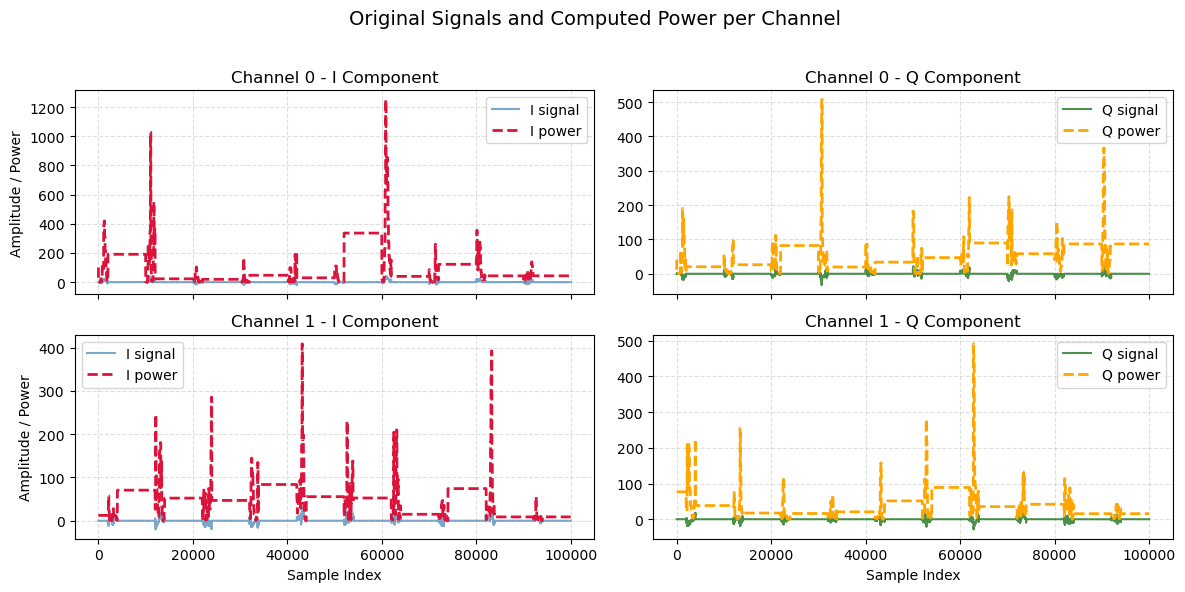

In [129]:
plot_power_and_signals(Wifi_output_data_after_interpolation_naive, result_naive, 2)

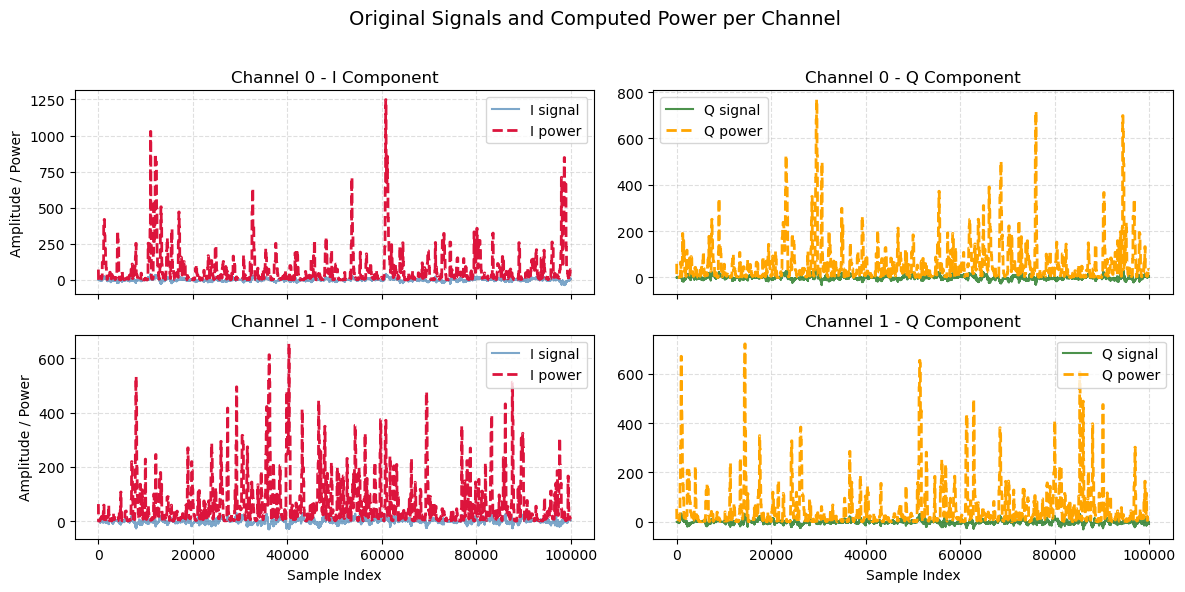

In [130]:
plot_power_and_signals(Channel_dict, result_ground_truth, 2)

In [131]:
def compute_power_differences(result, result_naive, result_ground_truth):
    """
    Compute elementwise differences of power arrays for each channel and component (I, Q)
    between result/result_naive and the ground truth.
    """
    diff_result = {}
    diff_naive = {}

    for ch in result.keys():
        diff_result[ch] = {
            'I': np.abs(result[ch]['I'] - result_ground_truth[ch]['I']),
            'Q': np.abs(result[ch]['Q'] - result_ground_truth[ch]['Q'])
        }
        diff_naive[ch] = {
            'I': np.abs(result_naive[ch]['I'] - result_ground_truth[ch]['I']),
            'Q': np.abs(result_naive[ch]['Q'] - result_ground_truth[ch]['Q'])
        }

    return diff_result, diff_naive


def plot_power_error_per_channel(diff_result, diff_naive, num_channels_to_plot):
    """
    Plot per-channel power errors (I and Q separately).
    Each channel gets two plots: I-error and Q-error.
    """
    fig, axs = plt.subplots(num_channels_to_plot, 2, figsize=(12, 3 * num_channels_to_plot), sharex=True)

    # Handle case where only one channel is plotted (so axs is 1D)
    if num_channels_to_plot == 1:
        axs = np.array([axs])

    for i in range(num_channels_to_plot):
    #for i in [7, 8, 9]: 
        samples = np.arange(len(diff_result[i]['I']))

        # ---- I component ----
        axs[i, 0].plot(samples, diff_result[i]['I'], label='Result vs GT', color='royalblue', linewidth=1.5)
        axs[i, 0].plot(samples, diff_naive[i]['I'], label='Naive vs GT', color='darkorange', linestyle='--', linewidth=1.5)
        axs[i, 0].set_title(f"Channel {i} - I Component Error")
        axs[i, 0].set_ylabel("Abs Power Difference")
        axs[i, 0].legend()
        axs[i, 0].grid(True, linestyle='--', alpha=0.5)

        # ---- Q component ----
        axs[i, 1].plot(samples, diff_result[i]['Q'], label='Result vs GT', color='royalblue', linewidth=1.5)
        axs[i, 1].plot(samples, diff_naive[i]['Q'], label='Naive vs GT', color='darkorange', linestyle='--', linewidth=1.5)
        axs[i, 1].set_title(f"Channel {i} - Q Component Error")
        axs[i, 1].legend()
        axs[i, 1].grid(True, linestyle='--', alpha=0.5)

    axs[-1, 0].set_xlabel("Sample Index")
    axs[-1, 1].set_xlabel("Sample Index")
    plt.suptitle("Error vs Ground Truth for Result and Naive Methods", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Compute differences
diff_result, diff_naive = compute_power_differences(result, result_naive, result_ground_truth)

# Plot first 3 channels (or however many you want)
#plot_power_error_per_channel(diff_result, diff_naive, num_channels_to_plot=10)

In [132]:
import pandas as pd

def compute_average_power_difference(diff_result, diff_naive):
    """
    Compute average absolute power difference (scalar) for each channel and component (I, Q)
    from the already-computed difference dictionaries.

    Returns a pandas DataFrame for easy display and further analysis.
    """
    data = []

    for ch in diff_result.keys():
        avg_result_I = np.mean(diff_result[ch]['I'])
        avg_result_Q = np.mean(diff_result[ch]['Q'])
        avg_naive_I = np.mean(diff_naive[ch]['I'])
        avg_naive_Q = np.mean(diff_naive[ch]['Q'])

        data.append({
            'Channel': ch,
            'Avg |I_diff| (Result vs GT)': avg_result_I,
            'Avg |Q_diff| (Result vs GT)': avg_result_Q,
            'Avg |I_diff| (Naive vs GT)': avg_naive_I,
            'Avg |Q_diff| (Naive vs GT)': avg_naive_Q
        })

    df = pd.DataFrame(data)
    return df

avg_diff_df = compute_average_power_difference(diff_result, diff_naive)

print("Average Absolute Power Difference per Channel:")
print(avg_diff_df)

Average Absolute Power Difference per Channel:
   Channel  Avg |I_diff| (Result vs GT)  Avg |Q_diff| (Result vs GT)  \
0        0                    75.458035                    53.856558   
1        1                    53.045171                    52.000499   
2        2                    35.404935                    41.372936   
3        3                    20.971761                    24.424020   
4        4                    10.171168                     9.752692   

   Avg |I_diff| (Naive vs GT)  Avg |Q_diff| (Naive vs GT)  
0                   79.668446                   46.606910  
1                   50.027575                   43.155289  
2                   33.820121                   43.654088  
3                   21.064621                   25.161678  
4                    9.907568                    9.785535  
